# The Perils in Tahiti
In our game of Seafall the 3rd island is named Tahiti. It has a crucial caveat when attempting endeavors on this island, "Reroll all minor successes rolled during endeavors here." On first thought, this doesn't sound too bad. Minor successes are only a single face on each die, but just how risky is it to step foot on this island?

In [1]:
%matplotlib inline

import itertools
import matplotlib
import matplotlib.pyplot
import numpy
import pandas
import scipy.misc
import scipy.special
import seaborn

In [2]:
# colormap for data visualizations
cmap = seaborn.cubehelix_palette(n_colors = 6, start = 1.5, rot = 1.5,
                                gamma = 1.5, hue = 1.0, dark = 0.525,
                                light = 0.96, reverse = False, as_cmap = True)

# Redefine the probability of rolling a blank
Without any modifications the chance of rolling a blank is $1/3$ and the chance of rolling a minor success is $1/6$. Now, we must account for the situation where every minor success is re-rolled. Again there is a $1/3$ of rolling a blank, but we might end up with additional rolls if another minor success turns up. Conceivably, an infinite sequence of rolling could occur if a minor success is repeatedly rolled over and over again. To calculate the chances of rolling a blank than requires us to write an equation that is infinitely long.

$$\frac{1}{3} + \frac{1}{6} \left(  \frac{1}{3} + \frac{1}{6} \left( \frac{1}{3} + \frac{1}{6} \left( \frac{1}{3} + \cdots \right.\right.\right.$$

Beginning to perform the mulitplication reveals a series,

$$\frac{1}{3} + \frac{1}{3} \cdot \frac{1}{6} + \frac{1}{3} \cdot \frac{1}{6 \cdot 6} + \frac{1}{3} \cdot \frac{1}{6 \cdot 6 \cdot 6} + \cdots$$

Conveniently, this is a geometric series, which converges to a known formula.

$$ \frac{1}{3} \sum_{k=0}^\infty \left(\frac{1}{6}\right)^k \Rightarrow \frac{1}{3} \cdot \frac{1}{1 - \frac{1}{6}} = 0.4$$


In [3]:
p_blank = 0.4

def prob_blank(num_blank, total_dice):
    if total_dice < num_blank:
        p = 0.0
    else:
        p = (p_blank)**num_blank * \
        (1-p_blank)**(total_dice-num_blank) * \
        scipy.misc.comb(total_dice, total_dice - num_blank)
    return p

def prob_blank_or_worse(num_blank, total_dice):
    if total_dice < num_blank:
        p = 0.0
    else:
        rng_blank = numpy.arange(num_blank, total_dice + 1)
        array_blank = [prob_blank(n, total_dice) for n in rng_blank]
        p = numpy.sum(array_blank)
    return p

In [4]:
row_blank = numpy.arange(1,16) # number of dice showing the blank face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp = numpy.zeros((numpy.size(row_blank),numpy.size(col_dice)))
prob = [prob_blank_or_worse(*i) for i in itertools.product(row_blank, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_blank, col_dice)]
for idx, val in enumerate(ind):
    sdp[val] = prob[idx]
sdp_dataframe = pandas.DataFrame(data = sdp, index = row_blank, columns = col_dice)
sdp_dataframe_stack = sdp_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_blank", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_blank"})
sdp_mask = numpy.triu(numpy.ones((15,15)), 1)
sdp_pivot = sdp_dataframe_stack.pivot("number_dice_pool", 
                                      "number_blank", 
                                      "probability_GTE_to_number_blank")

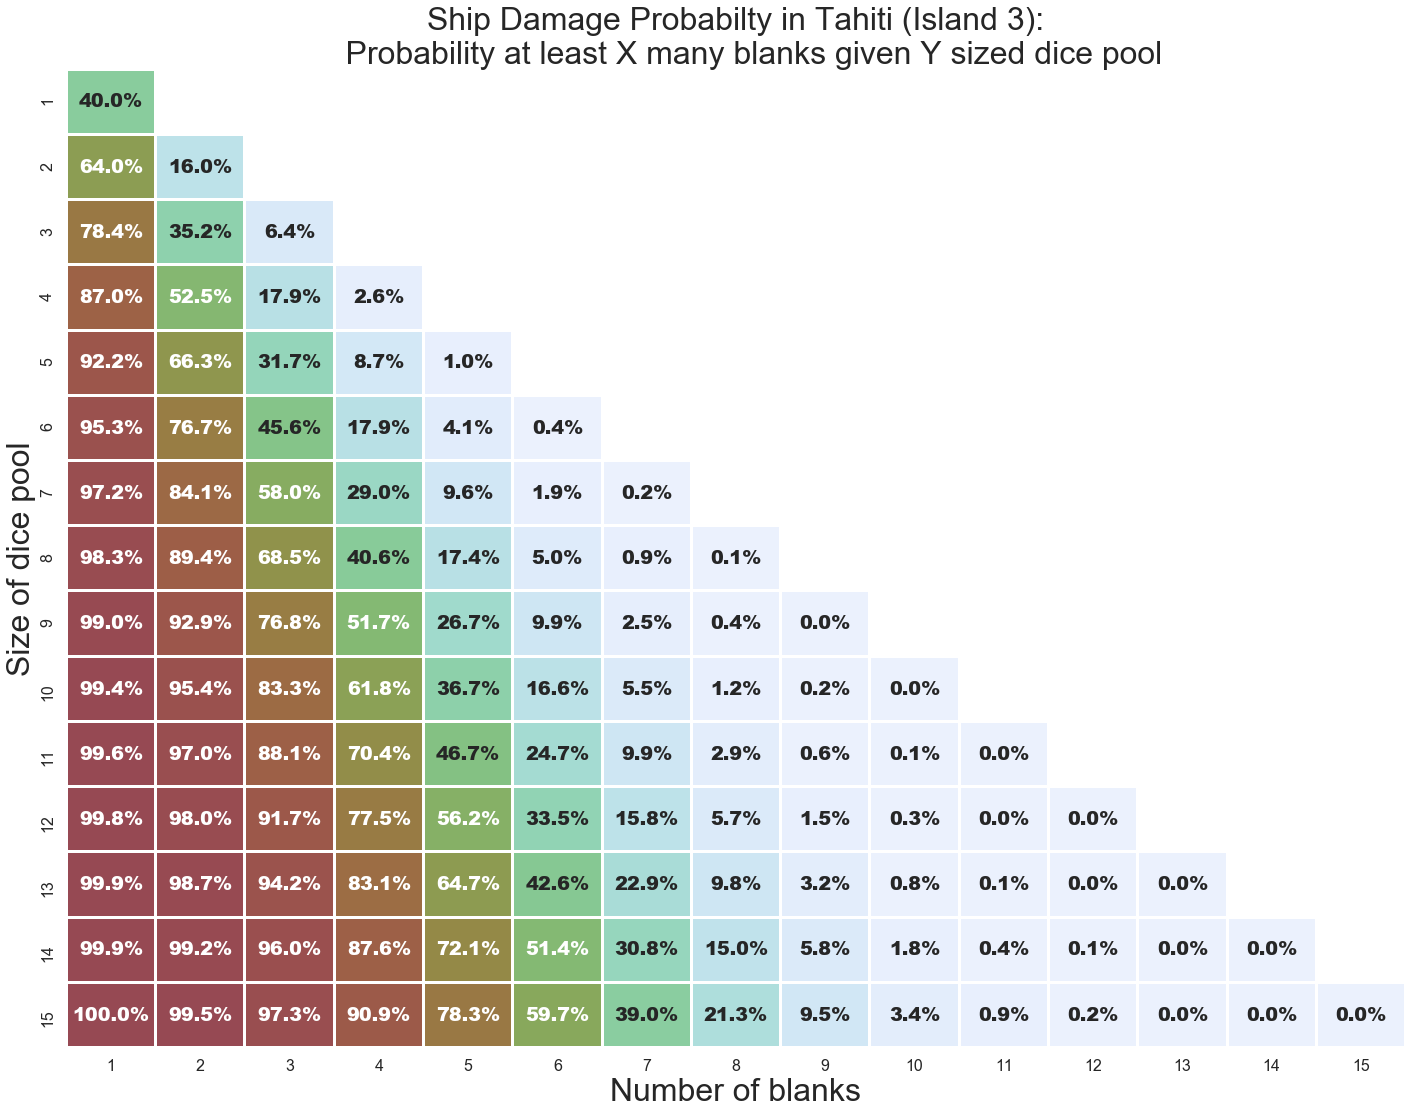

In [5]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
ax = seaborn.heatmap(sdp_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty in Tahiti (Island 3):
    Probability at least X many blanks given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of blanks", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig("sdp_gte_15_island3.pdf")

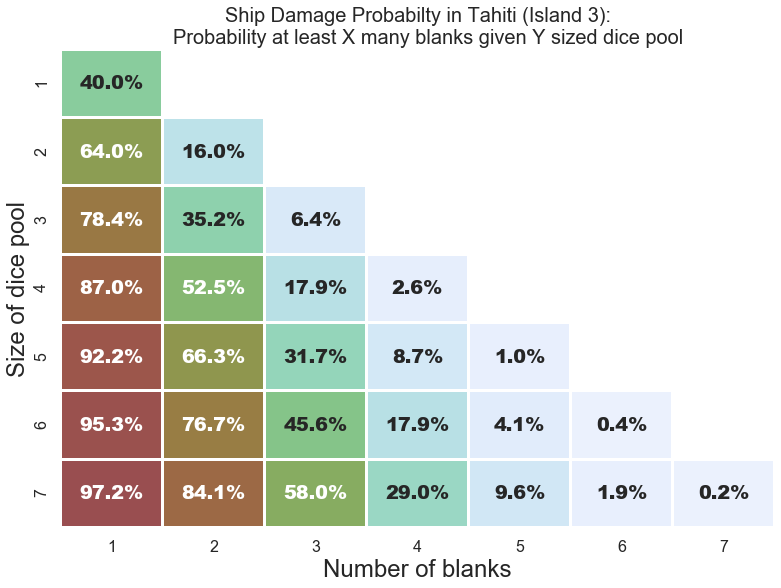

In [6]:
sdp_dataframe_7 = sdp_dataframe_stack.loc[(sdp_dataframe_stack["number_blank"] < 8) &
                                          (sdp_dataframe_stack["number_dice_pool"] < 8)]
sdp_mask_7 = numpy.triu(numpy.ones((7,7)), 1)
sdp_pivot_7 = sdp_dataframe_7.pivot("number_dice_pool", 
                                    "number_blank", 
                                    "probability_GTE_to_number_blank")
ax2 = seaborn.heatmap(sdp_pivot_7, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask_7, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)

ax2.set_title(
    """Ship Damage Probabilty in Tahiti (Island 3):
    Probability at least X many blanks given Y sized dice pool""",
    fontsize=20)
ax2.set_xlabel("Number of blanks", fontsize=24)
ax2.set_ylabel("Size of dice pool", fontsize=24)
fig = ax2.get_figure()
fig.savefig("sdp_gte_7_island3.pdf")

# At what cost?
The increase in probability from $0.\overline{3}$ to $0.4$ is enough to warrant a second thought before choosing to roll the dice. Some rolls become considerably less favorable. Consider rolling 4 dice and weighing the odds of 2 or more blanks. On a normal island this would happen $40.7\%$ of the time, but still favors success. On Tahiti the tables turn and the odds become worse than a coin toss, $52.5\%$.